In [1]:
# n_items  = 300
n_items = 1500

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import psutil


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, RandomRec, LinUCB, LinTS
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

from modified_ips import Exp_Smooth_IPS_Min, Exp_Smooth_IPS_Max

In [7]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 5.8


In [8]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/10/19 21:19:55 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/10/19 21:19:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/19 21:19:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/19 21:19:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [9]:
from rs_datasets import MovieLens

data = MovieLens("1m")

Оставим только 300 самых популярных айтемов

In [10]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:n_items]['item_id'].tolist()
# popular_items = logs['item_id'].tolist()

In [11]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (869950, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [12]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6040, 5), (1500, 3))

In [13]:
dataset = MovielensBanditDataset(data)

19-Oct-24 21:20:08, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


19-Oct-24 21:20:14, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
19-Oct-24 21:20:14, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model


ValueError: Length of values (1000209) does not match length of index (869950)

In [13]:
def optimize_ope_parameters(learner_action_dist, lambda_s, beta_1s, beta_2s, k=20000):
    CIPS_MSE = []
    for lambda_ in lambda_s:
        ope = InverseProbabilityWeighting(lambda_=lambda_, estimator_name='cips')
        CIPS_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(CIPS_MSE))
        best_lambda_ = lambda_s[best_idx]
        # print(np.array(CIPS_MSE)[best_idx])
        
    
    ESIPSMAX_MSE = []
    for beta_1 in beta_1s:
        ope = Exp_Smooth_IPS_Max(beta = beta_1)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_1 = beta_1s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    ESIPSMAX_MSE = []
    for beta_2 in beta_2s:
        ope = Exp_Smooth_IPS_Max(beta = beta_2)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_2 = beta_2s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    return {'lambda_':best_lambda_, 'beta_1': best_beta_1, 'beta_2': best_beta_2}

In [14]:
dict_opt_algo = {    
    'UCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'LinUCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'Random': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'LinTS': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
}

In [15]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB, LinTS)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, log_distinct.shape[0])
            if j == batch_idx*batch_size:
                break
            log_subset = log_distinct.iloc[batch_idx*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == batch_idx*batch_size:
                break
            bandit_feedback_subset = bandit_subset([batch_idx*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[batch_idx*batch_size:j] = action_dist
    return all_action_dist

In [16]:
def run_exp(learner_action_dist, lambda_, beta_1, beta_2):
    Vs = []
    CIs = []

    if n_items == 300:
        subsets = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 116921]
    elif n_items == 1500:
        subsets = [50000, 100000, 150000, 200000, 250000]
        
    for n_size in subsets:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),
                            Exp_Smooth_IPS_Max(beta = beta_1), Exp_Smooth_IPS_Min(beta = beta_2), InverseProbabilityWeighting(lambda_ = lambda_, estimator_name='cips')]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=100,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [17]:
import warnings
warnings.filterwarnings("ignore")

Подсчет Vs, CIs для разного числа негативных семплов для LinUCB:

In [18]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)
print('train_size:', bandit_feedback_train["n_rounds"])
print('test_size:', bandit_feedback_test["n_rounds"])

train_size: 608965
test_size: 260985


In [44]:
bandit_feedback_train['log'].toPandas()['item_idx'].unique().shape

(1500,)

In [43]:
bandit_feedback_test['log'].toPandas()['item_idx'].unique().shape

(1500,)

In [19]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 26.5


In [20]:
# estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
#                                                         dataset.len_list,
#                                                         bandit_feedback_train,
#                                                         bandit_feedback_test)

# np.save(f'estimated_rewards_by_reg_model_{n_items}.npy', estimated_rewards_by_reg_model)
estimated_rewards_by_reg_model = np.load(f'estimated_rewards_by_reg_model_{n_items}.npy')

In [21]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 35.8


In [22]:
param_borders_1 = {
    "coef": [0, 10],
}
param_borders_2 = {
    "eps": [-10, 10],
    "alpha": [0.001, 10]
}
param_borders_3 = {
    "distribution": ["popular_based", "relevance"],
    "alpha": [-0.5, 1000],
}
param_borders_4 = {
    "nu": [0.001, 10],
    "alpha": [100, 1500]
}

model_1 = UCB(exploration_coef = 0.018256352926343977, sample = True, seed = 123)
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1)

model_2 = LinUCB(eps = -9.99673647896505, alpha = 0.01558082488570561, regr_type = 'disjoint')
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2)

model_3 = RandomRec(distribution = 'relevance', alpha = 153.974492960275, seed=42)
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

model_4 = LinTS(nu = 9.585195706830213, alpha = 140.03084149742904, regr_type = 'disjoint')
learner_4 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_4)

In [21]:
# Take subset of train data to validate our model with OBP
if n_items == 300:
    bandit_feedback_subset = bandit_subset([0, 100000], bandit_feedback_train) #The first parameter is a slice of subset [a, b]
elif n_items == 1500:
    bandit_feedback_subset = bandit_subset([0, 200000], bandit_feedback_train) #The first parameter is a slice of subset [a, b]

In [22]:
print(learner_1.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_1, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-bfe29c6c-00ba-4149-b79a-4019d020973f
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
100%|█████████▉| 200/201 [00:41<00:00,  4.84it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.7773899633090898 and parameters: {'coef': 8.667320594802844}. Best is trial 0 with value: 0.7773899633090898.
100%|█████████▉| 200/201 [00:35<00:00,  5.62it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.7924701102134436 and parameters: {'coef': 3.358427236937782}. Best is trial 1 with value: 0.7924701102134436.
100%|█████████▉| 200/201 [00:34<00:00,  5.77it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.775750710408531 and parameters: {'coef': 9.670118562946552}. Best is trial 1 with value: 0.7924701102134436.
100%|█████████▉| 200/201 [00:35<00:00,  5.61it/s]
INFO:optuna.study.study:Trial 3 finished with value: 0.795252910179992 and parameters: {'coef': 2.836717954122271}. Best is tr

{'coef': 0.018256352926343977}


In [23]:
print('UCB params:')
print('coef =', learner_1.replay_model.coef)

UCB params:
coef = 0.018256352926343977


In [24]:
print(learner_2.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_2, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-5a4e56ff-8634-4b1f-953a-90fdd837cc4f
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
100%|██████████| 64/64 [00:17<00:00,  3.68it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.7239101553837708 and parameters: {'eps': 6.079658515430577, 'alpha': 2.9356645044637304}. Best is trial 0 with value: 0.7239101553837708.
100%|██████████| 64/64 [00:17<00:00,  3.71it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.8730492347711452 and parameters: {'eps': -1.6482493622865704, 'alpha': 8.553720888926668}. Best is trial 1 with value: 0.8730492347711452.
100%|██████████| 64/64 [00:17<00:00,  3.71it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.8588222799503217 and parameters: {'eps': 0.6962218890867771, 'alpha': 3.070985015744365}. Best is trial 1 with value: 0.8730492347711452.
100%|██████████| 64/64 [00:17<00:00,  3.66it/s]
INFO:optuna.study.study:Trial 3 finished with va

{'eps': -9.99673647896505, 'alpha': 0.01558082488570561}


In [25]:
print('LinUCB params:')
print('eps =', learner_2.replay_model.eps)
print('alpha =', learner_2.replay_model.alpha)

LinUCB params:
eps = -9.99673647896505
alpha = 0.01558082488570561


In [26]:
print(learner_3.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_3, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-198b3434-eaf9-4aa2-b393-356cf107656a
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
100%|█████████▉| 200/201 [00:44<00:00,  4.46it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.9127363826312207 and parameters: {'distribution': 'relevance', 'alpha': 153.974492960275}. Best is trial 0 with value: 0.9127363826312207.
100%|█████████▉| 200/201 [00:49<00:00,  4.05it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.8819748056589494 and parameters: {'distribution': 'popular_based', 'alpha': 28.36061488939054}. Best is trial 0 with value: 0.9127363826312207.
100%|█████████▉| 200/201 [00:47<00:00,  4.24it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.9127363826312207 and parameters: {'distribution': 'relevance', 'alpha': 628.2109720309597}. Best is trial 0 with value: 0.9127363826312207.
100%|█████████▉| 200/201 [00:47<00:00,  4.24it/s]
INFO:optuna.study.study:Trial 3 

{'distribution': 'relevance', 'alpha': 153.974492960275}


In [27]:
print('Random params:')
print('distribution = ', learner_3.replay_model.distribution)
print('alpha =', learner_3.replay_model.alpha)

Random params:
distribution =  relevance
alpha = 153.974492960275


In [28]:
print(learner_4.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_4, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-a45f9f8a-bc96-4b76-af40-5c83f26775ed
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
100%|██████████| 64/64 [00:39<00:00,  1.64it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.800107273419002 and parameters: {'nu': 6.32136653621247, 'alpha': 532.6771856172211}. Best is trial 0 with value: 0.800107273419002.
100%|██████████| 64/64 [00:39<00:00,  1.64it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.8392278537282559 and parameters: {'nu': 0.9776018780296625, 'alpha': 734.0456157166972}. Best is trial 1 with value: 0.8392278537282559.
100%|██████████| 64/64 [00:39<00:00,  1.60it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.7944811333883746 and parameters: {'nu': 5.989743729999022, 'alpha': 1296.0597634058363}. Best is trial 1 with value: 0.8392278537282559.
100%|██████████| 64/64 [00:40<00:00,  1.59it/s]
INFO:optuna.study.study:Trial 3 finished with value: 0.8

{'nu': 9.585195706830213, 'alpha': 140.03084149742904}


In [30]:
print('LinTS params:')
print('nu =', learner_4.replay_model.nu)
print('alpha =', learner_4.replay_model.alpha)

LinTS params:
nu = 9.585195706830213
alpha = 140.03084149742904


UCB:

In [33]:
print('momory usage:', psutil.virtual_memory().percent)

learner_1.fit(bandit_feedback_train)

learner_action_dist_1 = get_dist(learner_1)

opt_params_ips_1 = optimize_ope_parameters(learner_action_dist_1, dict_opt_algo['UCB']['lambda_s'], dict_opt_algo['UCB']['beta_1s'], dict_opt_algo['UCB']['beta_2s'])
print(opt_params_ips_1)

print('momory usage:', psutil.virtual_memory().percent)

Vs_1, CIs_1 = run_exp(learner_action_dist_1, opt_params_ips_1['lambda_'], opt_params_ips_1['beta_1'], opt_params_ips_1['beta_2'])

np.save(f'./Vs_CIs/Vs_1_opt_{n_items}.npy', Vs_1)
np.save(f'./Vs_CIs/CIs_1_opt_{n_items}.npy', CIs_1)
print('Vs:', Vs_1[-1])
print('CIs:', CIs_1[-1])

momory usage: 69.4


100%|██████████| 870/870 [02:54<00:00,  4.99it/s]


{'lambda_': 5, 'beta_1': 1, 'beta_2': 1}
momory usage: 47.3
n_size = 50000 time:  2.046412706375122
n_size = 100000 time:  9.980449676513672
n_size = 150000 time:  17.19672703742981
n_size = 200000 time:  20.816587209701538
n_size = 250000 time:  24.894405603408813
Vs: {'ipw': 0.8554971583080001, 'dm': 0.8590631411298472, 'sndr': 0.8396589967253302, 'snipw': 0.8396372264173048, 'ESIPSMAX': 0.8554971583080001, 'ESIPSMIN': 0.8554971583080001, 'cips': 0.8554971583080001}
CIs: {'ipw': {'mean': 0.8557368750081881, '95.0% CI (lower)': 0.8524799685643937, '95.0% CI (upper)': 0.8588398549950437}, 'dm': {'mean': 0.8590643949815508, '95.0% CI (lower)': 0.8590097453221859, '95.0% CI (upper)': 0.8591116112579561}, 'sndr': {'mean': 0.8396858560589149, '95.0% CI (lower)': 0.8378638946565177, '95.0% CI (upper)': 0.8410763920144381}, 'snipw': {'mean': 0.8398724990459944, '95.0% CI (lower)': 0.8366759718961242, '95.0% CI (upper)': 0.8429179533581335}, 'ESIPSMAX': {'mean': 0.8557368750081881, '95.0% CI 

LinUCB

In [34]:
print('momory usage:', psutil.virtual_memory().percent)

learner_2.fit(bandit_feedback_train)

learner_action_dist_2 = get_dist(learner_2)

opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['LinUCB']['lambda_s'], dict_opt_algo['LinUCB']['beta_1s'], dict_opt_algo['LinUCB']['beta_2s'])
print(opt_params_ips_2)

print('momory usage:', psutil.virtual_memory().percent)

Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])

np.save(f'./Vs_CIs/Vs_2_opt_{n_items}.npy', Vs_2)
np.save(f'./Vs_CIs/CIs_2_opt_{n_items}.npy', CIs_2)
print('Vs:', Vs_2[-1])
print('CIs:', CIs_2[-1])

momory usage: 45.7


100%|██████████| 230/230 [01:06<00:00,  3.43it/s]


{'lambda_': 5, 'beta_1': 1, 'beta_2': 1}
momory usage: 59.7
n_size = 50000 time:  1.9471683502197266
n_size = 100000 time:  3.819830894470215
n_size = 150000 time:  6.418330430984497
n_size = 200000 time:  13.040663480758667
n_size = 250000 time:  19.58219861984253
Vs: {'ipw': 0.8555986033341478, 'dm': 0.8601400566421075, 'sndr': 0.8686707351456993, 'snipw': 0.8686914499612147, 'ESIPSMAX': 0.8555986033341478, 'ESIPSMIN': 0.8555986033341478, 'cips': 0.8549455625649531}
CIs: {'ipw': {'mean': 0.8554601452222569, '95.0% CI (lower)': 0.8534051056496228, '95.0% CI (upper)': 0.8577471141995497}, 'dm': {'mean': 0.8601413284966963, '95.0% CI (lower)': 0.8600855854046034, '95.0% CI (upper)': 0.8601876405194054}, 'sndr': {'mean': 0.8686559593173827, '95.0% CI (lower)': 0.867037489682756, '95.0% CI (upper)': 0.8698859268745575}, 'snipw': {'mean': 0.8685508730861377, '95.0% CI (lower)': 0.8664643861527526, '95.0% CI (upper)': 0.8708728385371782}, 'ESIPSMAX': {'mean': 0.8554601452222569, '95.0% CI (

Random

In [35]:
print('momory usage:', psutil.virtual_memory().percent)

learner_3.fit(bandit_feedback_train)

learner_action_dist_3 = get_dist(learner_3)

opt_params_ips_3 = optimize_ope_parameters(learner_action_dist_3, dict_opt_algo['Random']['lambda_s'], dict_opt_algo['Random']['beta_1s'], dict_opt_algo['Random']['beta_2s'])
print(opt_params_ips_3)
print('momory usage:', psutil.virtual_memory().percent)

Vs_3, CIs_3 = run_exp(learner_action_dist_3, opt_params_ips_3['lambda_'], opt_params_ips_3['beta_1'], opt_params_ips_3['beta_2'])

np.save(f'./Vs_CIs/Vs_3_opt_{n_items}.npy', Vs_3)
np.save(f'./Vs_CIs/CIs_3_opt_{n_items}.npy', CIs_3)
print('Vs:', Vs_3[-1])
print('CIs:', CIs_3[-1])

momory usage: 59.1


100%|██████████| 870/870 [02:56<00:00,  4.93it/s]


{'lambda_': 1.5, 'beta_1': 1, 'beta_2': 1}
momory usage: 69.8
n_size = 50000 time:  2.0672450065612793
n_size = 100000 time:  3.999314785003662
n_size = 150000 time:  9.912440061569214
n_size = 200000 time:  14.491345882415771
n_size = 250000 time:  18.201205492019653
Vs: {'ipw': 0.8522387088953949, 'dm': 0.8601257803901408, 'sndr': 0.8701962930595905, 'snipw': 0.8701423663664696, 'ESIPSMAX': 0.8522387088953949, 'ESIPSMIN': 0.8522387088953949, 'cips': 0.8522365648662271}
CIs: {'ipw': {'mean': 0.8522390115211758, '95.0% CI (lower)': 0.8504761584886388, '95.0% CI (upper)': 0.8534704985573767}, 'dm': {'mean': 0.8601270258861183, '95.0% CI (lower)': 0.8600727118081798, '95.0% CI (upper)': 0.860173944847215}, 'sndr': {'mean': 0.8702163477288889, '95.0% CI (lower)': 0.8687823120803276, '95.0% CI (upper)': 0.8713043719472895}, 'snipw': {'mean': 0.8701426753497512, '95.0% CI (lower)': 0.8683427886592299, '95.0% CI (upper)': 0.8714000332151528}, 'ESIPSMAX': {'mean': 0.8522390115211758, '95.0% C

LinTS

In [23]:
print('momory usage:', psutil.virtual_memory().percent)

learner_4.fit(bandit_feedback_train)

learner_action_dist_4 = get_dist(learner_4)

opt_params_ips_4 = optimize_ope_parameters(learner_action_dist_4, dict_opt_algo['LinTS']['lambda_s'], dict_opt_algo['LinTS']['beta_1s'], dict_opt_algo['LinTS']['beta_2s'])
print(opt_params_ips_4)

print('momory usage:', psutil.virtual_memory().percent)

Vs_4, CIs_4 = run_exp(learner_action_dist_4, opt_params_ips_4['lambda_'], opt_params_ips_4['beta_1'], opt_params_ips_4['beta_2'])

np.save(f'./Vs_CIs/Vs_4_opt_{n_items}.npy', Vs_4)
np.save(f'./Vs_CIs/CIs_4_opt_{n_items}.npy', CIs_4)
print('Vs:', Vs_4[-1])
print('CIs:', CIs_4[-1])

momory usage: 35.8


100%|██████████| 230/230 [02:29<00:00,  1.54it/s]


{'lambda_': inf, 'beta_1': 1, 'beta_2': 1}
momory usage: 52.8
n_size = 50000 time:  2.001920461654663
n_size = 100000 time:  3.9399099349975586
n_size = 150000 time:  6.46820068359375
n_size = 200000 time:  12.099448204040527
n_size = 250000 time:  16.386751890182495
Vs: {'ipw': 0.8232426039466626, 'dm': 0.8589117655330732, 'sndr': 0.8047594202102524, 'snipw': 0.805782300400707, 'ESIPSMAX': 0.8232426039466626, 'ESIPSMIN': 0.8232426039466626, 'cips': 0.8232426039466626}
CIs: {'ipw': {'mean': 0.8134743454954848, '95.0% CI (lower)': 0.6665891529465441, '95.0% CI (upper)': 0.9877196277686574}, 'dm': {'mean': 0.8589093079990985, '95.0% CI (lower)': 0.858838205133023, '95.0% CI (upper)': 0.858969845950737}, 'sndr': {'mean': 0.8053754770104353, '95.0% CI (lower)': 0.7317091055712848, '95.0% CI (upper)': 0.8637763936275583}, 'snipw': {'mean': 0.7962212187366094, '95.0% CI (lower)': 0.6524513412066136, '95.0% CI (upper)': 0.9667709008241804}, 'ESIPSMAX': {'mean': 0.8134743454954848, '95.0% CI (

### Теперь строим графики:

In [24]:
estimated_rewards_by_reg_model = np.load(f'estimated_rewards_by_reg_model_{n_items}.npy')

In [25]:
ucb_v = np.load(f'./Vs_CIs/Vs_1_opt_{n_items}.npy', allow_pickle=True)
ucb_ci = np.load(f'./Vs_CIs/CIs_1_opt_{n_items}.npy', allow_pickle=True)

linucb_v = np.load(f'./Vs_CIs/Vs_2_opt_{300}.npy', allow_pickle=True)
linucb_ci = np.load(f'./Vs_CIs/CIs_2_opt_{n_items}.npy', allow_pickle=True)

random_v = np.load(f'./Vs_CIs/Vs_3_opt_{n_items}.npy', allow_pickle=True)
random_ci = np.load(f'./Vs_CIs/CIs_3_opt_{n_items}.npy', allow_pickle=True)

lints_v = np.load(f'./Vs_CIs/Vs_4_opt_{n_items}.npy', allow_pickle=True)
lints_ci = np.load(f'./Vs_CIs/CIs_4_opt_{n_items}.npy', allow_pickle=True)

In [26]:
# 300: 116921
# 1000: 282099

In [27]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(7, figsize=(10, 10))
    
    if n_items == 300:
        x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, bandit_feedback_test['n_rounds']]
    elif n_items == 1500:
        x = [50000, 100000, 150000, 200000, 250000]

    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()
    plt.tight_layout()

In [28]:
# plot_disjoint_res(ucb_v, ucb_ci, 'UCB')

In [29]:
# plot_disjoint_res(linucb_v, linucb_ci, 'LinUCB')

In [30]:
# def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
#     fig, ax = plt.subplots(7, figsize=(10, 15))
#     x = [50000, 100000, 150000, 200000, 250000, 282099]
#     colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
#     i=0
#     for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

#         ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

#         ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
#         ax[i].set_title(name)
        
#         i = i+1
#     fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
#     fig.legend()
#     plt.tight_layout()

In [31]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if n_items == 300:
        x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 116921]
    elif n_items == 1500:
        x = [50000, 100000, 150000, 200000, 250000]
        
    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

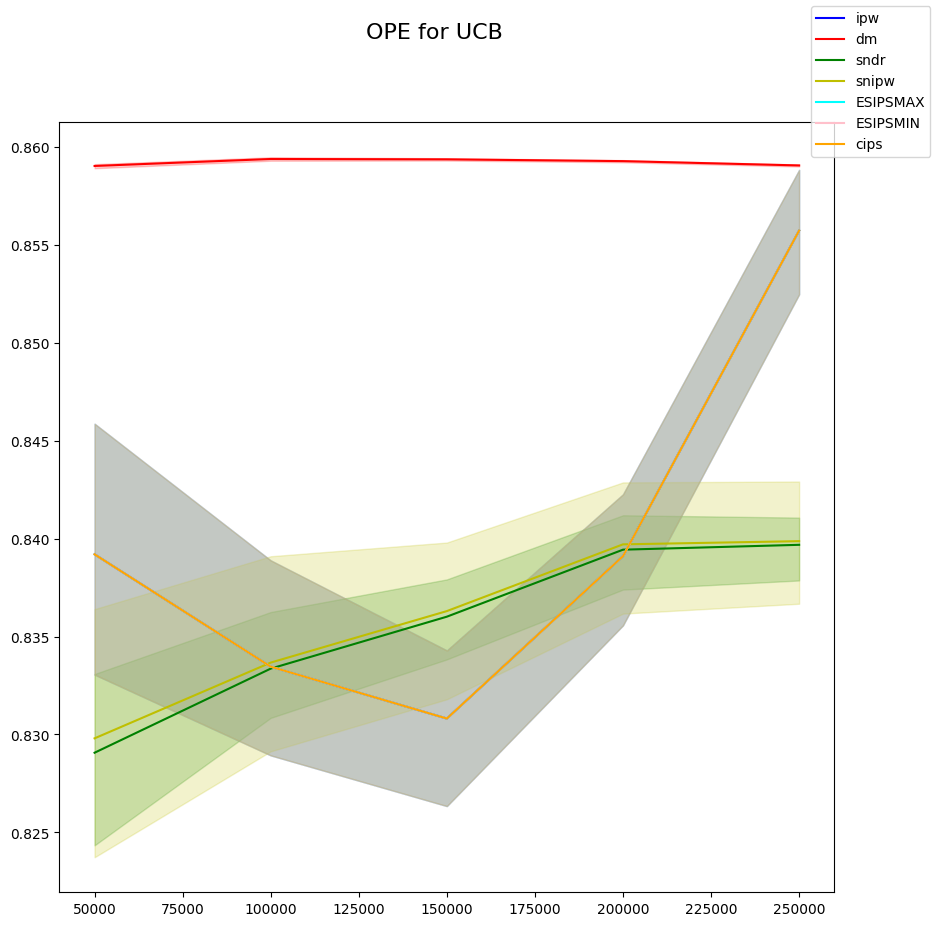

In [32]:
plot_join_res(ucb_v, ucb_ci, 'UCB')

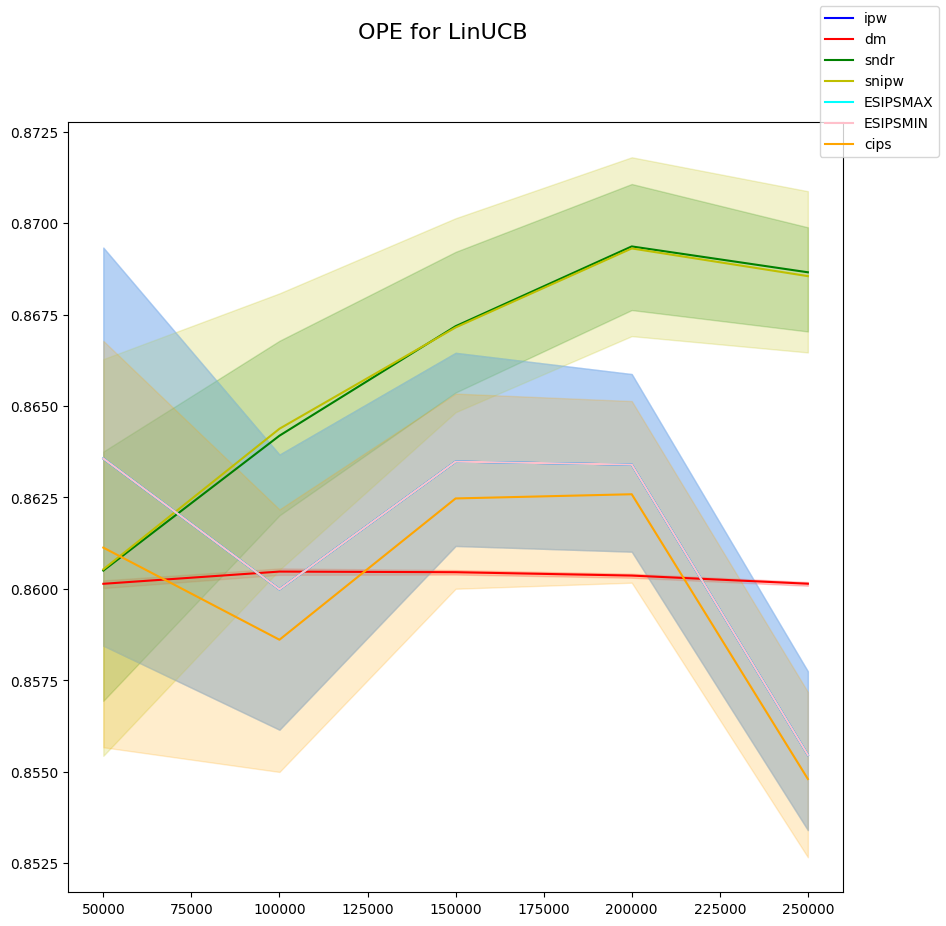

In [33]:
plot_join_res(linucb_v, linucb_ci, 'LinUCB')

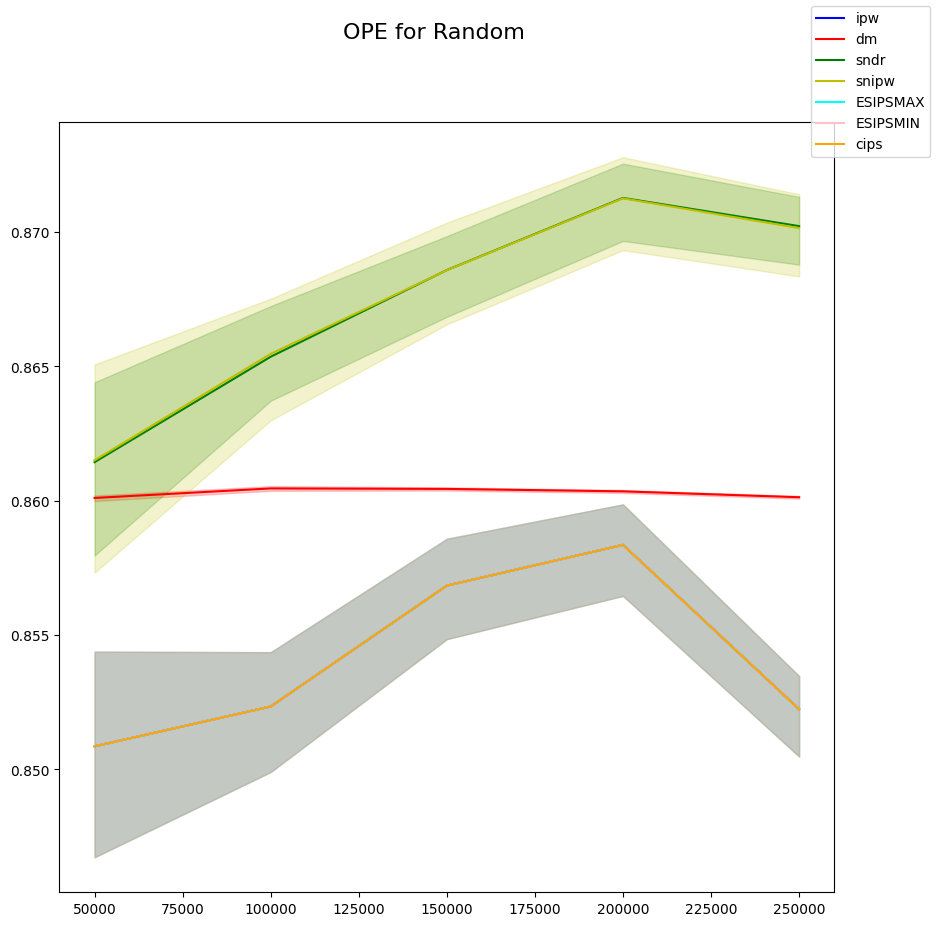

In [34]:
plot_join_res(random_v, random_ci, 'Random')

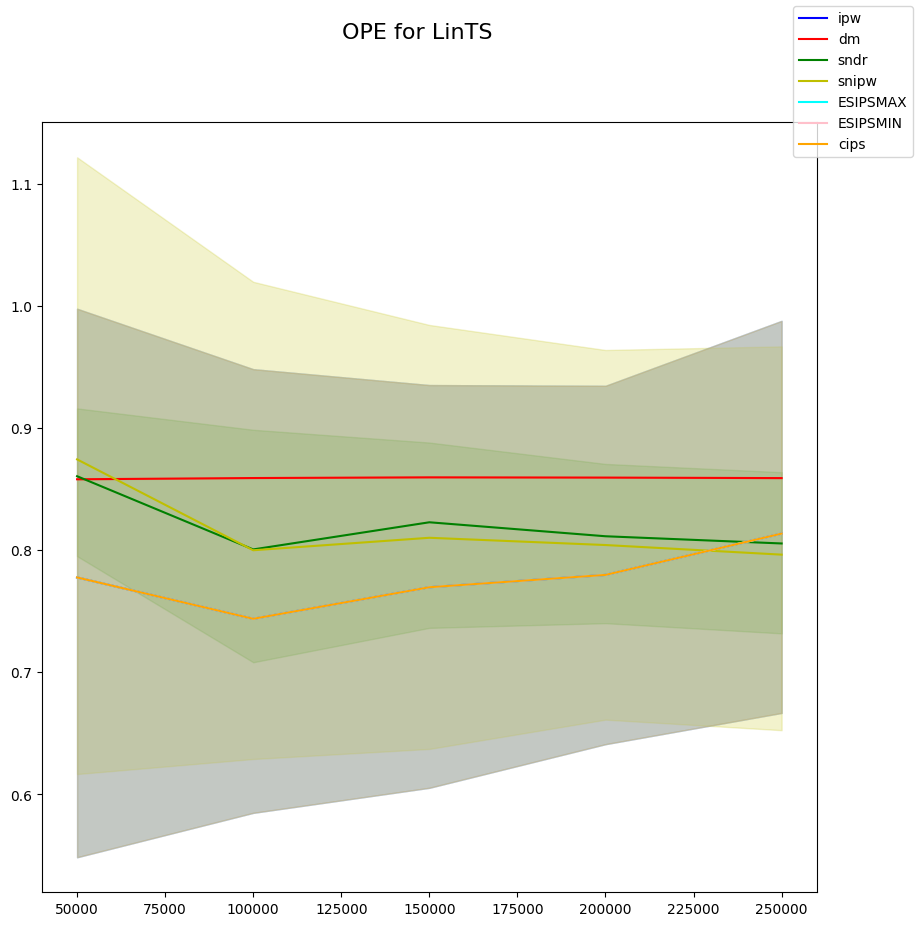

In [35]:
plot_join_res(lints_v, lints_ci, 'LinTS')

In [36]:
print("Estimated values USB")
print(ucb_v[-1])
print("Estimated values Lin USB")
print(linucb_v[-1])
print("Estimated values Random")
print(random_v[-1])
print("Estimated values LinTS")
print(lints_v[-1])

print("Estimated confidence intervals UCB:")
print(pd.DataFrame(ucb_ci[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(linucb_ci[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(random_ci[-1]).to_string())
print("Estimated confidence intervals LinTS:")
print(pd.DataFrame(lints_ci[-1]).to_string())

Estimated values USB
{'ipw': 0.8554971583080001, 'dm': 0.8590631411298472, 'sndr': 0.8396589967253302, 'snipw': 0.8396372264173048, 'ESIPSMAX': 0.8554971583080001, 'ESIPSMIN': 0.8554971583080001, 'cips': 0.8554971583080001}
Estimated values Lin USB
{'ipw': 0.9040775354758178, 'dm': 0.9065918149592272, 'sndr': 0.9055306573112463, 'snipw': 0.905389119054321, 'ESIPSMAX': 0.9040775354758178, 'ESIPSMIN': 0.9040775354758178, 'cips': 0.9039677445414737}
Estimated values Random
{'ipw': 0.8522387088953949, 'dm': 0.8601257803901408, 'sndr': 0.8701962930595905, 'snipw': 0.8701423663664696, 'ESIPSMAX': 0.8522387088953949, 'ESIPSMIN': 0.8522387088953949, 'cips': 0.8522365648662271}
Estimated values LinTS
{'ipw': 0.8232426039466626, 'dm': 0.8589117655330732, 'sndr': 0.8047594202102524, 'snipw': 0.805782300400707, 'ESIPSMAX': 0.8232426039466626, 'ESIPSMIN': 0.8232426039466626, 'cips': 0.8232426039466626}
Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw  ESI

In [33]:
# # n_negatives = [0, 50, 100, 150, 200, 250, 300, 350, 400]
# n_negatives = [250]

# for n_neg in n_negatives:
#     print('n_neg:', n_neg)
#     print(1, 'momory usage:', psutil.virtual_memory().percent)
#     bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True, n_neg=n_neg)
#     print(2, 'momory usage:', psutil.virtual_memory().percent)
        
#     model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
#     learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                         replay_model=model_2)
#     learner_2.fit(bandit_feedback_train)
#     print(3, 'momory usage:', psutil.virtual_memory().percent)
    
#     # learner_action_dist_2 = get_dist(learner_2)
    
#     # np.save(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy', learner_action_dist_2)
#     learner_action_dist_2 = np.load(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy')
    
#     print(4, 'momory usage:', psutil.virtual_memory().percent)
    
#     opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['Lin-UCB']['lambda_s'], dict_opt_algo['Lin-UCB']['beta_1s'], dict_opt_algo['Lin-UCB']['beta_2s'])
#     print(opt_params_ips_2)
    
#     print(5, 'momory usage:', psutil.virtual_memory().percent)
    
#     Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])
    
#     np.save(f'./Vs_CIs/Vs_2_opt_{n_neg}.npy', Vs_2)
#     np.save(f'./Vs_CIs/CIs_2_opt_{n_neg}.npy', CIs_2)
#     print('Vs:', Vs_2[-1])
#     print('CIs:', CIs_2[-1])

In [37]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('UCB')
learner_1.fit(bandit_feedback_train)

print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 53.1
UCB


100%|██████████| 229/229 [00:57<00:00,  4.01it/s]                               


{'hr@1': 0.00042192209446822136, 'mrr@1': 0.00042192209446822136, 'ndcg@1': 0.00042192209446822136, 'cov@1': 0.004666666666666667}


100%|██████████| 229/229 [00:54<00:00,  4.20it/s]


{'hr@3': 0.0016914870265592335, 'mrr@3': 0.0009252269854602146, 'ndcg@3': 0.0011196424252037924, 'cov@3': 0.011333333333333334}


100%|██████████| 229/229 [00:54<00:00,  4.18it/s]


{'hr@10': 0.007122691956198781, 'mrr@10': 0.0019476041120384826, 'ndcg@10': 0.0031487060500188825, 'cov@10': 0.034666666666666665}


In [38]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('LinUCB')
learner_2.fit(bandit_feedback_train)

print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 74.6
LinUCB


100%|██████████| 229/229 [00:26<00:00,  8.77it/s]


{'hr@1': 0.009680566667821595, 'mrr@1': 0.009680566667821595, 'ndcg@1': 0.009680566667821595, 'cov@1': 0.048}


100%|██████████| 229/229 [00:26<00:00,  8.73it/s]


{'hr@3': 0.024055972694867485, 'mrr@3': 0.015828069372663667, 'ndcg@3': 0.017933279029472064, 'cov@3': 0.08733333333333333}


100%|██████████| 229/229 [00:26<00:00,  8.69it/s]


{'hr@10': 0.06206915447810427, 'mrr@10': 0.021904305003727365, 'ndcg@10': 0.03115547097218819, 'cov@10': 0.17066666666666666}


In [39]:
print('momory usage:', psutil.virtual_memory().percent)

print('Random')
learner_3.fit(bandit_feedback_train)

print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 65.4
Random


100%|██████████| 229/229 [00:54<00:00,  4.19it/s]


{'hr@1': 0.0006666385397380184, 'mrr@1': 0.0006666385397380184, 'ndcg@1': 0.0006666385397380184, 'cov@1': 0.818}


100%|██████████| 229/229 [00:54<00:00,  4.23it/s]


{'hr@3': 0.0019095476443250893, 'mrr@3': 0.0011841817911899702, 'ndcg@3': 0.001369196388731991, 'cov@3': 0.9913333333333333}


100%|██████████| 229/229 [00:54<00:00,  4.24it/s]


{'hr@10': 0.0072211477445680485, 'mrr@10': 0.0019945451281279344, 'ndcg@10': 0.0031804203059038858, 'cov@10': 1.0}


In [40]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('LinTS')
learner_4.fit(bandit_feedback_train)

print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 76.5
LinTS


100%|██████████| 229/229 [01:39<00:00,  2.29it/s]


{'hr@1': 0.0005809443732582917, 'mrr@1': 0.0005809443732582917, 'ndcg@1': 0.0005809443732582917, 'cov@1': 0.2693333333333333}


100%|██████████| 229/229 [01:40<00:00,  2.27it/s]


{'hr@3': 0.0016687193135554814, 'mrr@3': 0.0009377551161915929, 'ndcg@3': 0.0011230816085633288, 'cov@3': 0.31266666666666665}


100%|██████████| 229/229 [01:40<00:00,  2.27it/s]


{'hr@10': 0.004609327271982165, 'mrr@10': 0.0012551300714850227, 'ndcg@10': 0.002018784475954638, 'cov@10': 0.5313333333333333}
